# Simulation

The model fitted in Ott et al.'s paper has a few additional regressors beyond the decision values, to account for specific trials in which participants might have some bias. Importantly, while departure from optimal behaviour in such trials might reflect bias, it might reflect abstraction of states found in these "special cases". If the brain performs state abstraction and that these "special cases" trials have a similar transition probability and reward, they may become lumped together into a state class in participants's representation in the task. If this is the case, then we would expect participants to exhibit consistent behaviour in these trials (where optimal behaviour would predict different behaviour in different trials). Therefore, as a starting point, we will model the data using only 1 parameter associated with the decision value, to avoid shadowing the effect we are after by creating redundant regressors. 

We will use the following model

$$p(accept) = \frac{1}{1+e^{-\eta}}$$

Where

$$\eta = \beta DV $$

The first step in setting up our analysis pipeline is ensuring that our model can accurately retrieve the parameters of interest in the data. To that end, we will simulate data with known ground truth effects, fit our models and make sure that the parameters can be retrieve from the data. We will start with the simplest possible case: simulating data according to the decision values associated with dynamic programming (i.e. optimal policy).

We simulate the data as follows:

$$\eta = \beta_0 + \beta DV + \epsilon$$

Where:
- $\beta_0 \sim \mathcal{N}(0, 1)$ across participants
- $\beta_{dv} \sim \mathcal{N}(2, 1)$ across participants
- $\epsilon \sim \mathcal{N}(0, 5)$ for each trial

In [1]:
import numpy as np
import pandas as pd
from scipy.special import expit
import pymc as pm
import arviz as az
from scipy import stats
from sklearn.cluster import AgglomerativeClustering
# initialize numpy rng seed:
rng = np.random.default_rng(12345)
az.style.use("arviz-doc")

from utils import state_classes_from_lbl, avg_reduce_mdp, reduced2full_value
from MarkovDecisionProcess import MDP
from TaskConfig import LimitedEnergyTask
import matplotlib.pyplot as plt

# Create task of limited energy:
task = LimitedEnergyTask()
task.build()
# Create full MDP and compute solution:
task_mdp = MDP(task.states, task.tp, task.r, s2i=task.s2i)
_, Q_full = task_mdp.backward_induction()
# Calculate decision values
DVs = Q_full[:, 1] - Q_full[:, 0]
DVs_norm = stats.zscore(DVs)

# Generate random design matrices for simulated subjects:
n_trials = 40
n_subjects = 20
noise_sigma = 5
e_start = 3
design_matrices = task.design_matrix(n_trials, n_subjects)

# Generate simulated data based on the dynamic programming planning:
data = pd.DataFrame()
betas_mu = [0, 2]
betas_var = [1, 1]
subs_betas = []
for sub in range(len(design_matrices)):
    sub_design = design_matrices[sub]
    sub_beta_mu = [np.random.normal(betas_mu[i], betas_var[i]) for i in range(len(betas_mu))]
    subs_betas.append(sub_beta_mu)
    for trial_i, trial in sub_design.iterrows():
        # Extract state values:
        # Energy depends on previous actions
        if trial_i == 0:
            e = e_start
        else:
            e = e_next
        o = trial["offer"]
        cc = trial["costs"]
        # For the last trial in the segment:
        if trial.segment < sub_design["segment"].max():
            fc = sub_design[sub_design["segment"] == trial.segment + 1]["costs"].iat[0]
        else:
            fc = np.random.choice(task.C, 1)
        
        # Get the decision value:
        DV = DVs_norm[task.s2i[(int(e), int(o), int(cc), int(fc), int(trial["trial_within_seg"]))]]

        # Determine response:
        y = np.random.binomial(1, expit(sub_beta_mu[0] + sub_beta_mu[1] * DV))
        if y == 1 and e >= cc:
            e_next = e - cc
        elif y == 1 and e < cc:
            e_next = 0
        elif y == 0 and e < task.max_energy:
            e_next = e + 1
        else:
            e_next = 6

        data = pd.concat([data, pd.DataFrame({
            'subject': sub+1,
            'trial': trial_i,
            'DV': DV,
            'y': y
        }, index=[0])])

data = data.reset_index(drop=True)
subject_codes, subject_labels = pd.factorize(data["subject"])

C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_8964\4233751221.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  DV = DVs_norm[task.s2i[(int(e), int(o), int(cc), int(fc), int(trial["trial_within_seg"]))]]


Sampling: [beta0, beta1, mu_b0, mu_b1, sigma_b0, sigma_b1, y]


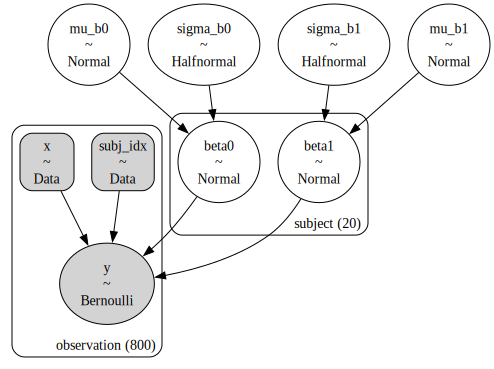

In [2]:
# Extract the data of one subject:
subj_idx_raw, subj_labels = pd.factorize(data["subject"])
coords = {
    "observation": np.arange(len(data)),
    "subject": subj_labels,
}

with pm.Model(coords=coords) as binomial_regression_model:
    x = pm.Data("x", data["DV"], dims="observation")
    subj_idx = pm.Data("subj_idx", subj_idx_raw, dims="observation")
    # Hyperpriors
    mu_b0 = pm.Normal('mu_b0', mu=0, sigma=2)
    sigma_b0 = pm.HalfNormal('sigma_b0', sigma=2)
    mu_b1 = pm.Normal('mu_b1', mu=0, sigma=2)
    sigma_b1= pm.HalfNormal('sigma_b1', sigma=2)
    
    # Intercept for each subject, distributed around group mean mu_b0
    b0 = pm.Normal('beta0', mu=mu_b0, sigma=sigma_b0, dims="subject")
    # Intercept for each subject, distributed around group mean mu_b1
    b1 = pm.Normal('beta1', mu=mu_b1, sigma=sigma_b1, dims="subject")
    
    # Expected value
    mu = b0[subj_idx] + b1[subj_idx] * x
    pm.Bernoulli("y", logit_p=mu, observed=data["y"], dims="observation")
    # Sample prior:
    idata = pm.sample_prior_predictive(draws=100)

pm.model_to_graphviz(binomial_regression_model)


Before we can fit the model to the simulated data, let's perform prior predictive checks (i.e. simulate data based on the priors we have selected to make sure that they are appropriate):

c:\Users\alexander.lepauvre\Documents\GitHub\state-abstraction\.venv\Lib\site-packages\arviz\plots\hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


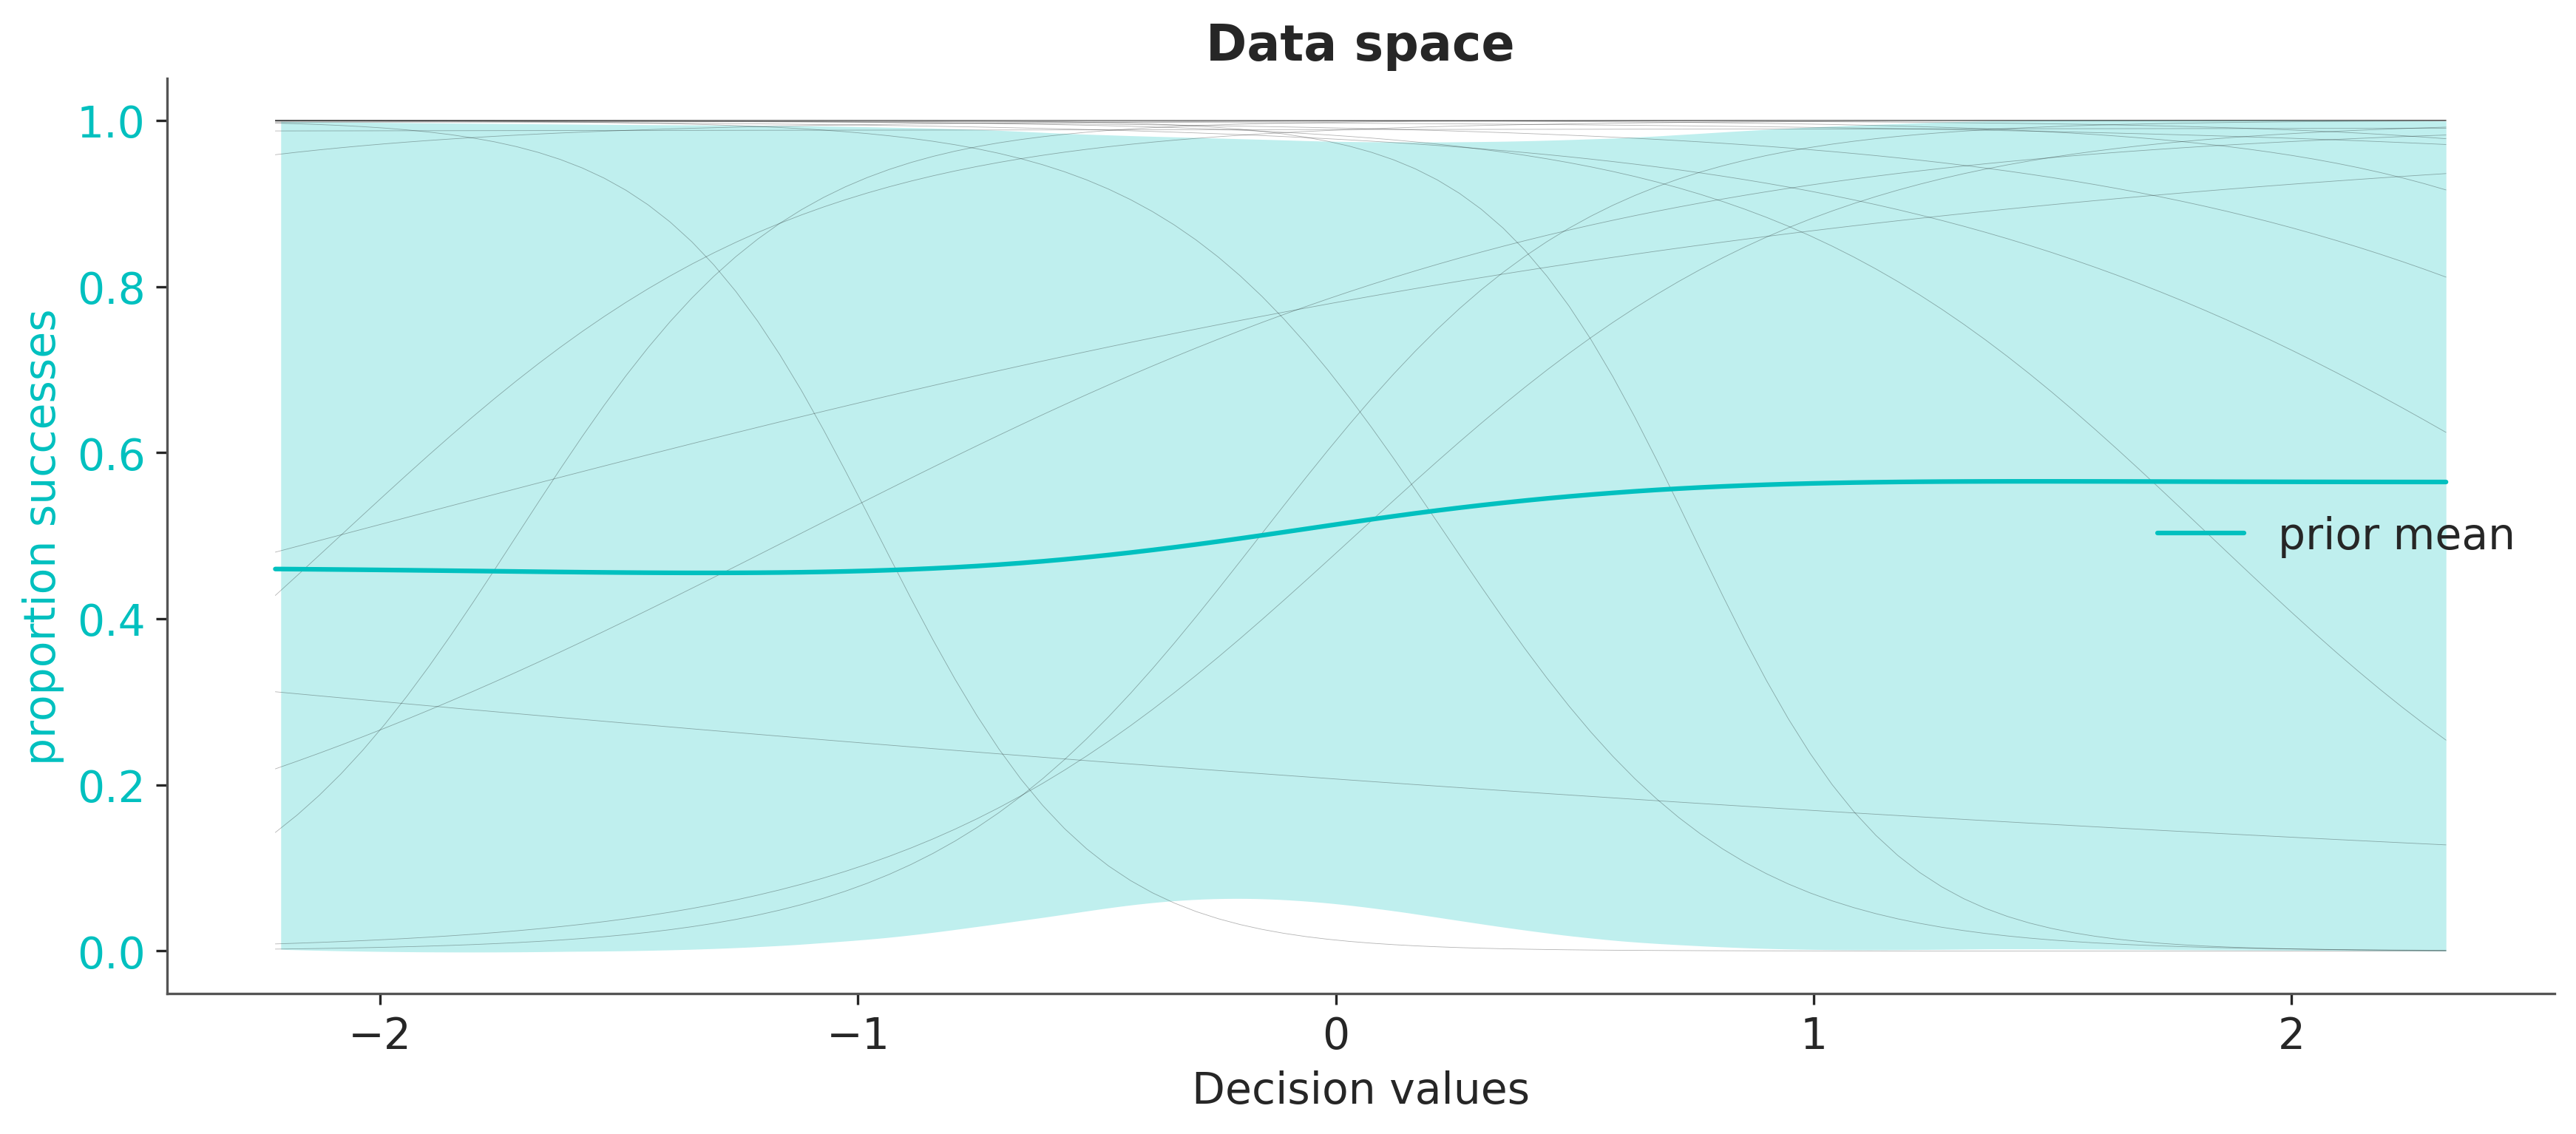

In [3]:
fig, ax = plt.subplots()
x_grid = np.linspace(data["DV"].min(), data["DV"].max(), 100)
mu_b0 = idata.prior["mu_b0"].stack(sample=("chain", "draw"))  # (sample,)
mu_b1 = idata.prior["mu_b1"].stack(sample=("chain", "draw"))  # (sample,)
sub_b0 = idata.prior["beta0"].stack(sample=("chain", "draw"))  # (sample,)
sub_b1 = idata.prior["beta1"].stack(sample=("chain", "draw"))  # (sample,)

# 3) Compute linear predictor and logistic
eta = mu_b0.values[:, None] + mu_b1.values[:, None] * x_grid[None, :]  # (sample, x)
p = expit(eta)  # probabilities in (0,1)
for i in range(sub_b1.shape[0]):
    ax.plot(x_grid, expit(sub_b0[i, np.random.choice(1, 100)].values + sub_b1[i, np.random.choice(1, 100)].values * x_grid), color='k', linewidth=0.2, alpha=0.3)
az.plot_hdi(x_grid, p,
            hdi_prob=0.95,
            fill_kwargs={"alpha": 0.25, "linewidth": 0},
            ax=ax,
            color="C1",)
ax.plot(x_grid, np.mean(p, axis=0), label="prior mean", color="C1")
ax.set(xlabel="Decision values", title="Data space")
ax.set_ylabel("proportion successes", color="C1")
ax.tick_params(axis="y", labelcolor="C1")
ax.legend()
plt.show()

Now let's fit the data:

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0, beta1]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1236 seconds.
C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_8964\2980865003.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


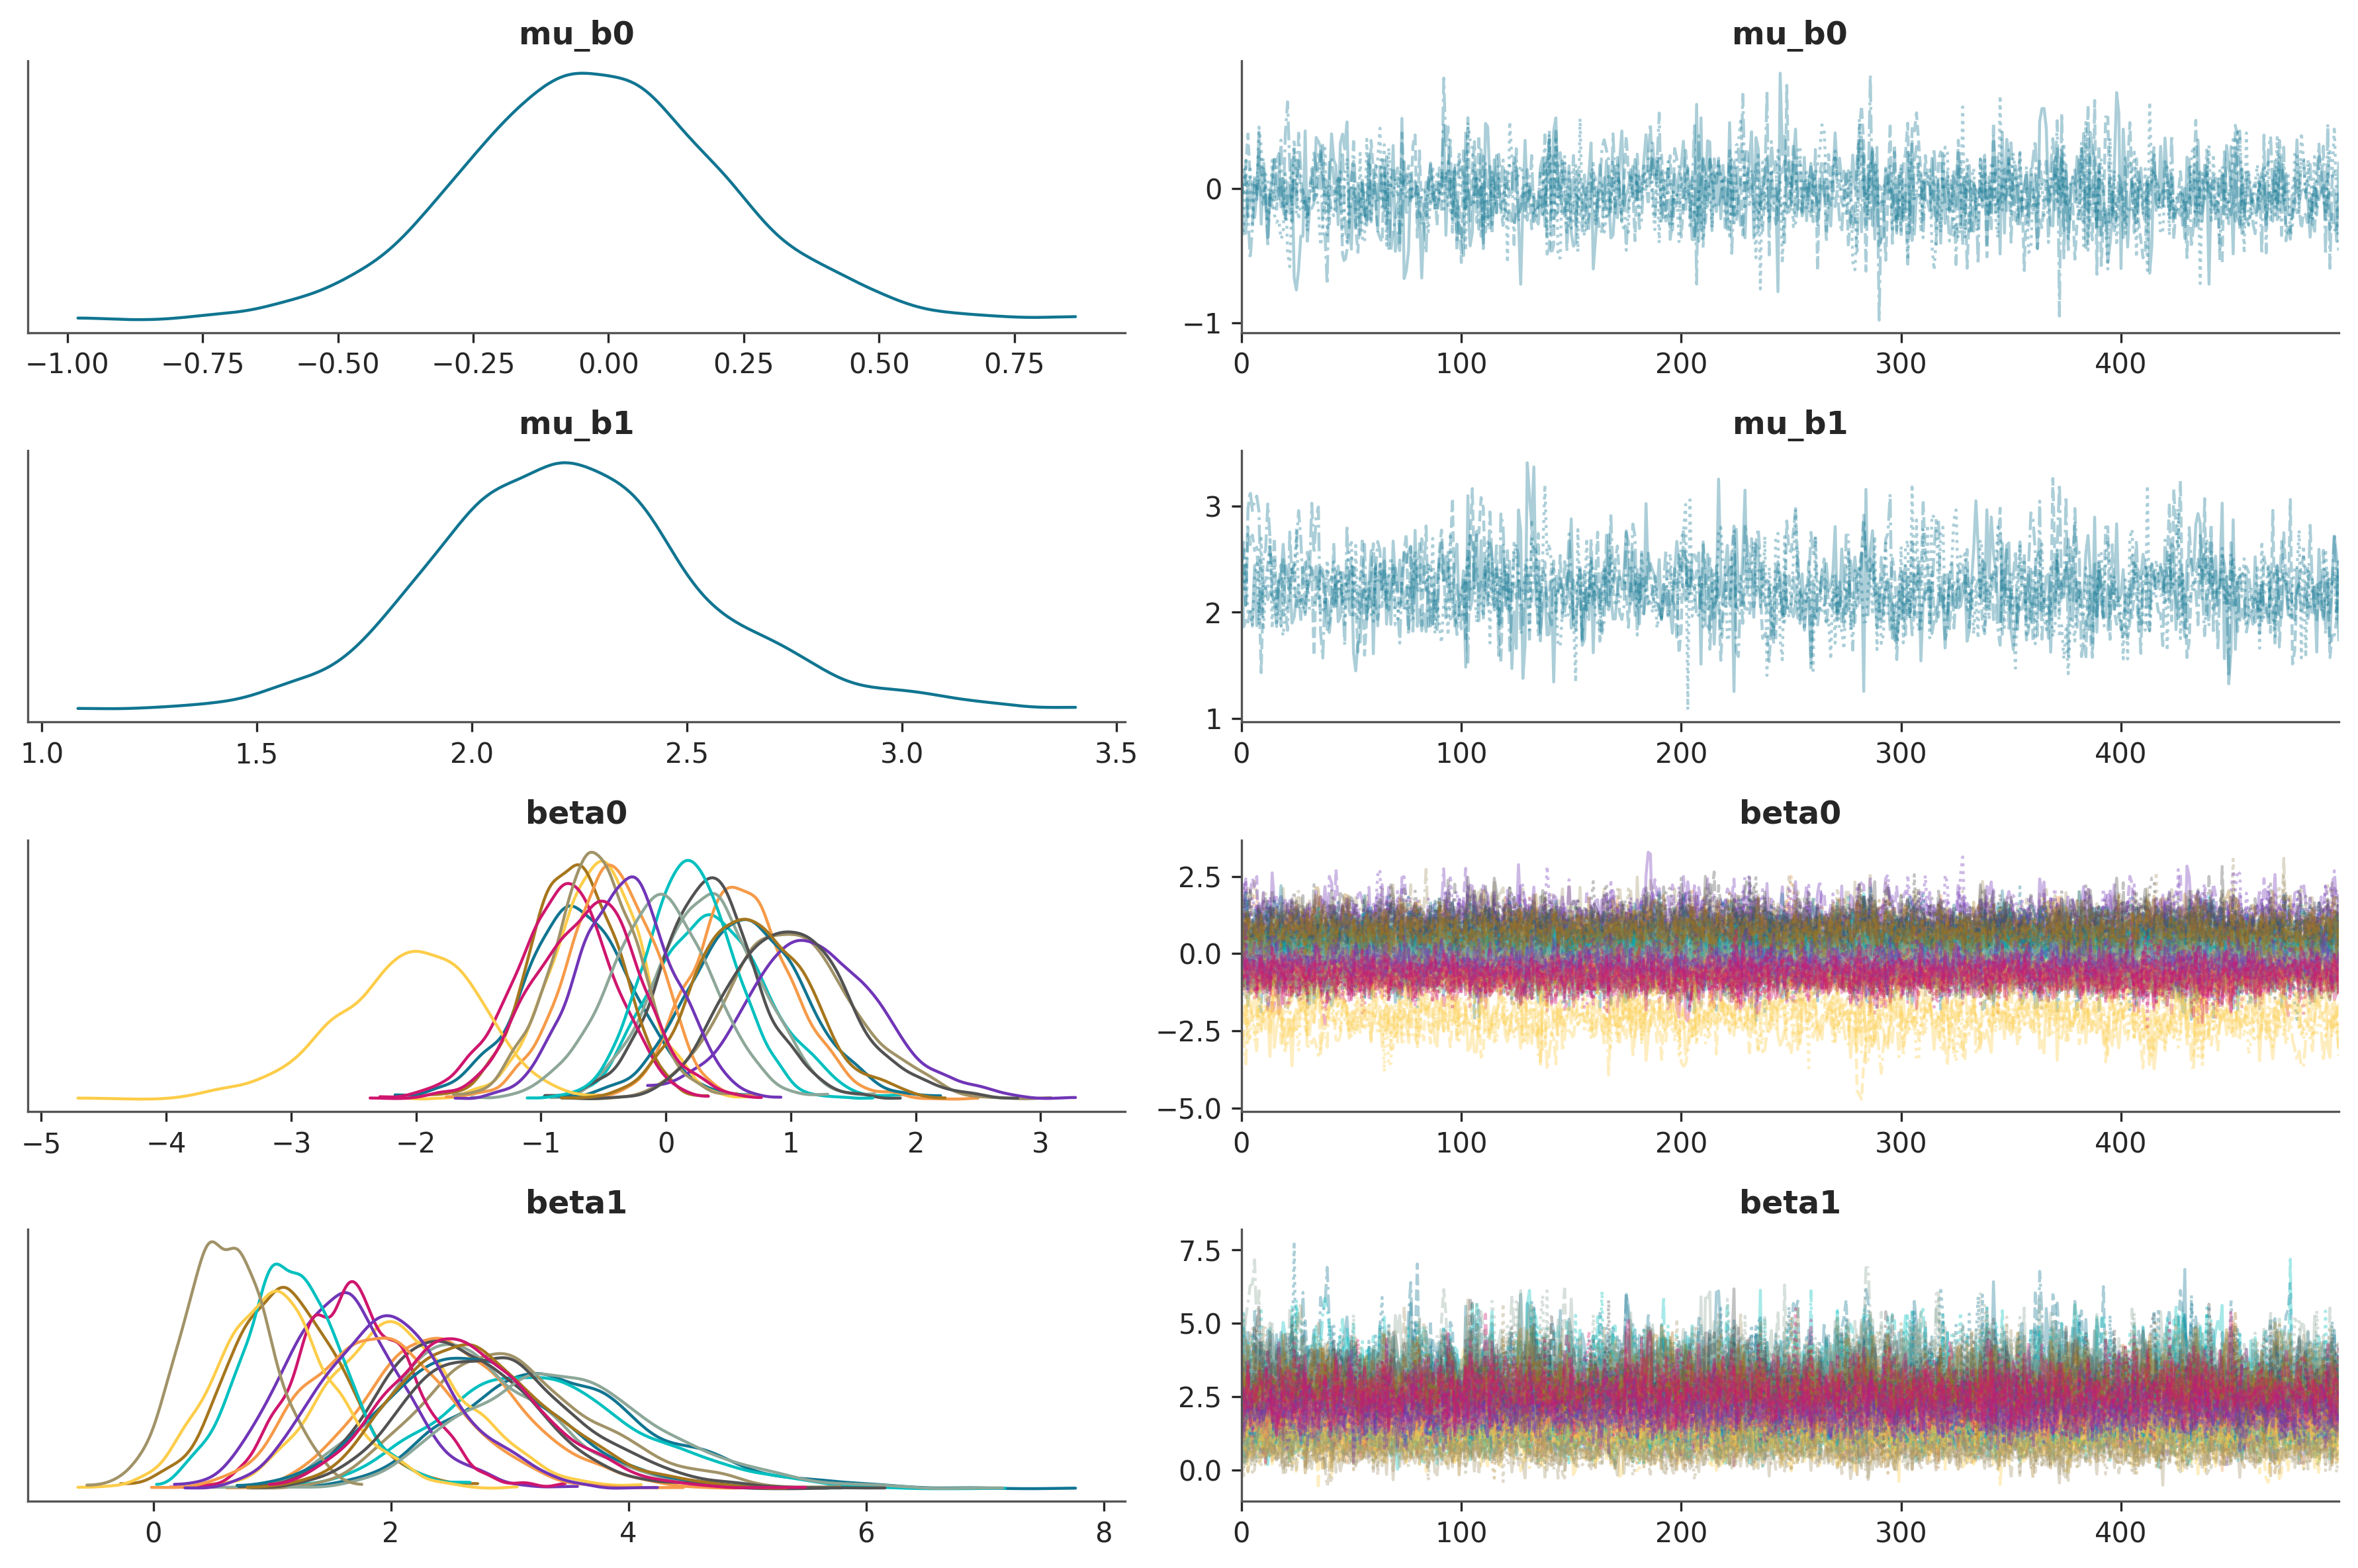

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_b0     -0.028  0.246  -0.489    0.434      0.005    0.006    2045.0   
mu_b1      2.224  0.319   1.611    2.833      0.010    0.009    1155.0   
beta0[1]  -0.712  0.444  -1.581    0.085      0.008    0.011    2735.0   
beta0[2]   0.374  0.449  -0.410    1.222      0.010    0.010    2101.0   
beta0[3]   0.617  0.402  -0.129    1.353      0.009    0.009    1869.0   
beta0[4]  -0.555  0.358  -1.230    0.127      0.008    0.009    2119.0   
beta0[5]   0.347  0.406  -0.433    1.085      0.009    0.008    2018.0   
beta0[6]   1.016  0.500   0.072    1.951      0.013    0.010    1400.0   
beta0[7]   0.346  0.399  -0.347    1.178      0.008    0.012    2298.0   
beta0[8]  -0.738  0.342  -1.372   -0.100      0.007    0.007    2208.0   
beta0[9]   1.198  0.534   0.175    2.221      0.014    0.011    1450.0   
beta0[10] -0.842  0.401  -1.597   -0.114      0.008    0.010    2486.0   
beta0[11]  0.650  0.467  -0.166    1.575      0.011    0.009    1894.0   
beta0[12]  0.197  0.353  -0.446    0.866      0.008    0.008    1945.0   
beta0[13] -0.441  0.362  -1.164    0.188      0.008    0.009    2000.0   
beta0[14] -2.083  0.573  -3.218   -1.084      0.018    0.015    1099.0   
beta0[15] -0.050  0.419  -0.783    0.797      0.008    0.009    2692.0   
beta0[16] -0.570  0.348  -1.229    0.070      0.007    0.008    2240.0   
beta0[17]  0.995  0.488   0.069    1.891      0.014    0.010    1302.0   
beta0[18]  0.694  0.448  -0.159    1.523      0.010    0.010    1901.0   
beta0[19] -0.323  0.377  -1.041    0.356      0.008    0.008    2302.0   
beta0[20] -0.636  0.427  -1.447    0.155      0.010    0.011    1975.0   
beta1[1]   3.447  0.883   1.897    5.142      0.022    0.021    1874.0   
beta1[2]   3.291  0.855   1.742    4.916      0.022    0.019    1606.0   
beta1[3]   2.481  0.634   1.374    3.748      0.016    0.014    1669.0   
beta1[4]   2.070  0.589   1.032    3.205      0.011    0.014    2782.0   
beta1[5]   2.645  0.704   1.328    3.917      0.017    0.018    1782.0   
beta1[6]   3.034  0.739   1.648    4.409      0.021    0.016    1377.0   
beta1[7]   2.572  0.642   1.377    3.729      0.015    0.016    1828.0   
beta1[8]   1.129  0.473   0.229    2.017      0.011    0.011    1960.0   
beta1[9]   1.603  0.496   0.682    2.542      0.013    0.011    1583.0   
beta1[10]  1.705  0.479   0.859    2.589      0.010    0.011    2674.0   
beta1[11]  2.679  0.717   1.284    3.974      0.017    0.015    1763.0   
beta1[12]  1.187  0.428   0.383    2.020      0.010    0.010    1779.0   
beta1[13]  1.916  0.609   0.813    3.060      0.013    0.014    2215.0   
beta1[14]  1.033  0.499   0.160    2.035      0.015    0.012    1171.0   
beta1[15]  3.485  0.849   2.020    5.115      0.024    0.024    1347.0   
beta1[16]  0.616  0.366  -0.036    1.337      0.008    0.008    2061.0   
beta1[17]  2.890  0.723   1.644    4.294      0.019    0.016    1565.0   
beta1[18]  2.729  0.674   1.552    4.030      0.017    0.018    1704.0   
beta1[19]  2.004  0.555   0.991    3.053      0.013    0.013    2039.0   
beta1[20]  2.638  0.652   1.416    3.821      0.015    0.014    2120.0   
sigma_b0   0.964  0.229   0.547    1.383      0.008    0.005     780.0   
sigma_b1   1.096  0.294   0.624    1.695      0.010    0.007     845.0   

           ess_tail  r_hat  
mu_b0        1446.0   1.00  
mu_b1         870.0   1.00  
beta0[1]     1494.0   1.00  
beta0[2]     1498.0   1.00  
beta0[3]     1685.0   1.00  
beta0[4]     1544.0   1.00  
beta0[5]     1478.0   1.00  
beta0[6]     1499.0   1.00  
beta0[7]     1322.0   1.00  
beta0[8]     1676.0   1.00  
beta0[9]     1430.0   1.00  
beta0[10]    1609.0   1.00  
beta0[11]    1675.0   1.00  
beta0[12]    1366.0   1.00  
beta0[13]    1492.0   1.00  
beta0[14]    1101.0   1.00  
beta0[15]    1596.0   1.00  
beta0[16]    1315.0   1.00  
beta0[17]    1453.0   1.00  
beta0[18]    1325.0   1.01  
beta0[19]    1520.0   1.00  
beta0[20]    1277.0   1.00  
beta1[1]     1

In [4]:
with binomial_regression_model:
    idata = pm.sample(500, tune=500)

az.plot_trace(idata, var_names=["mu_b0", "mu_b1", "beta0", "beta1"], combined=True)
plt.tight_layout()
plt.show()
az.summary(idata)

The results highlight that we are well able to retrieve the parameters we have injected in the data: the effect of decision value is close to 2, which is exactly what we have set. Now, let's try to simulate data based on decision values associated with state abstraction representation of the task. 

# Simulating data with state abstraction plan:

The aim of this project is to test whether participants rely on state abstraction to perform complicated tasks. We rely on the bisimulation distance metric from Ferns et al., which yield a distance for each pairs of states. On this basis, we can reduce the size of the MDP at various levels of granularity. Importantly, we don't know whether participants resort to such techniques and if they do, to which level of the granularity they reduce the MDP. Therefore, we need to fit the data using decision values calculated using MDP at various granularity levels and find which level fits the data the best (0 being no state abstraction at all). To do so, we need to make sure that the various DV we have can be dissociated from each other. If we pick abstractions that are not too dissimilar from each other, the resulting DV associated with each will be highly similar and therefore we don't be able to discriminate between them. To determine the kind of differences we can pick up experimentally, we can once again rely on simulated data: we can simulate data using DV obtained from an arbitrary abstraction levels, then fit data using DV from any abstraction level and perform model comparison to see whether we can tell them appart. 

In [ ]:
# Load the distance matrix:
states_dist_mat = np.load('distance_matrix.npy')

# Compute decision values associated with different abstraction levels:
DVs = dict()
eps_range = np.arange(0, 0.5, 0.05)
for eps in eps_range: #unique_dist:
    # Find states clusters
    states_lbl = AgglomerativeClustering(distance_threshold=eps, 
                                         n_clusters=None, linkage='complete', metric='precomputed').fit(states_dist_mat).labels_
    # Create state classes:
    state_classes = state_classes_from_lbl(task.states, states_lbl)
    # Reduce the MDP accordingly:
    statesR, tpR, rR, class_of_state = avg_reduce_mdp(state_classes, task_mdp.tp, task_mdp.r, task_mdp.s2i)
    # Create reduced MDP:
    task_mdp_reduced = MDP(statesR, tpR, rR)
    # Solve the MDP:
    V_R, Q_R = task_mdp_reduced.backward_induction()
    # Project back to full space:
    V, Q = reduced2full_value(class_of_state, V_R, Q_R)
    DVs[f'eps: {eps:.2f}'] = stats.zscore(Q[:, 1] - Q[:, 0])


In [ ]:
# Simulate data:
# Generate random design matrices for simulated subjects:
n_trials = 40
n_subjects = 20
noise_sigma = 5
e_start = 3
design_matrices = task.design_matrix(n_trials, n_subjects)
sim_dv_eps = 0.3

# Generate simulated data based on the dynamic programming planning:
data = pd.DataFrame()
betas_mu = [0, 2]
betas_var = [1, 1]
decision_noise = 1
subs_betas = []
for sub in range(len(design_matrices)):
    sub_design = design_matrices[sub]
    sub_beta_mu = [np.random.normal(betas_mu[i], betas_var[i]) for i in range(len(betas_mu))]
    subs_betas.append(sub_beta_mu)
    for trial_i, trial in sub_design.iterrows():
        # Extract state values:
        # Energy depends on previous actions
        if trial_i == 0:
            e = e_start
        else:
            e = e_next
        o = trial["offer"]
        cc = trial["costs"]
        # For the last trial in the segment:
        if trial.segment < sub_design["segment"].max():
            fc = sub_design[sub_design["segment"] == trial.segment + 1]["costs"].iat[0]
        else:
            fc = np.random.choice(task.C, 1)
        
        # Get the decision value:
        DV = DVs[f'eps: {sim_dv_eps:.2f}'][task.s2i[(int(e), int(o), int(cc), int(fc), int(trial["trial_within_seg"]))]]

        # Determine response:
        y = np.random.binomial(1, expit(sub_beta_mu[0] + sub_beta_mu[1] * DV + np.random.normal(0, decision_noise, size=1)))
        if y == 1 and e >= cc:
            e_next = e - cc
        elif y == 1 and e < cc:
            e_next = 0
        elif y == 0 and e < task.max_energy:
            e_next = e + 1
        else:
            e_next = 6

        data = pd.concat([data, pd.DataFrame({
            'subject': sub+1,
            'trial': trial_i,
            'y': y,
            **{f'DV, eps={eps:.2f}': DVs[f'eps: {eps:.2f}'][task.s2i[(int(e), int(o), int(cc), int(fc), int(trial["trial_within_seg"]))]] 
               for eps in eps_range}
        }, index=[0])])

data = data.reset_index(drop=True)
subj_idx_raw, subj_labels = pd.factorize(data["subject"])
coords = {
    "observation": np.arange(len(data)),
    "subject": subj_labels,
}

C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_8964\1841519418.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  DV = DVs[f'eps: {sim_dv_eps:.1f}'][task.s2i[(int(e), int(o), int(cc), int(fc), int(trial["trial_within_seg"]))]]
C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_8964\1841519418.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  **{f'DV, eps={eps:.1f}': DVs[f'eps: {eps:.1f}'][task.s2i[(int(e), int(o), int(cc), int(fc), int(trial["trial_within_seg"]))]]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0, beta1]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1265 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0, beta1]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1183 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0, beta1]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1911 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0, beta1]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2563 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0, beta1]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 3660 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0, beta1]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 3279 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0, beta1]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2305 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0, beta1]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 3736 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0, beta1]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2934 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0, beta1]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2307 seconds.


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

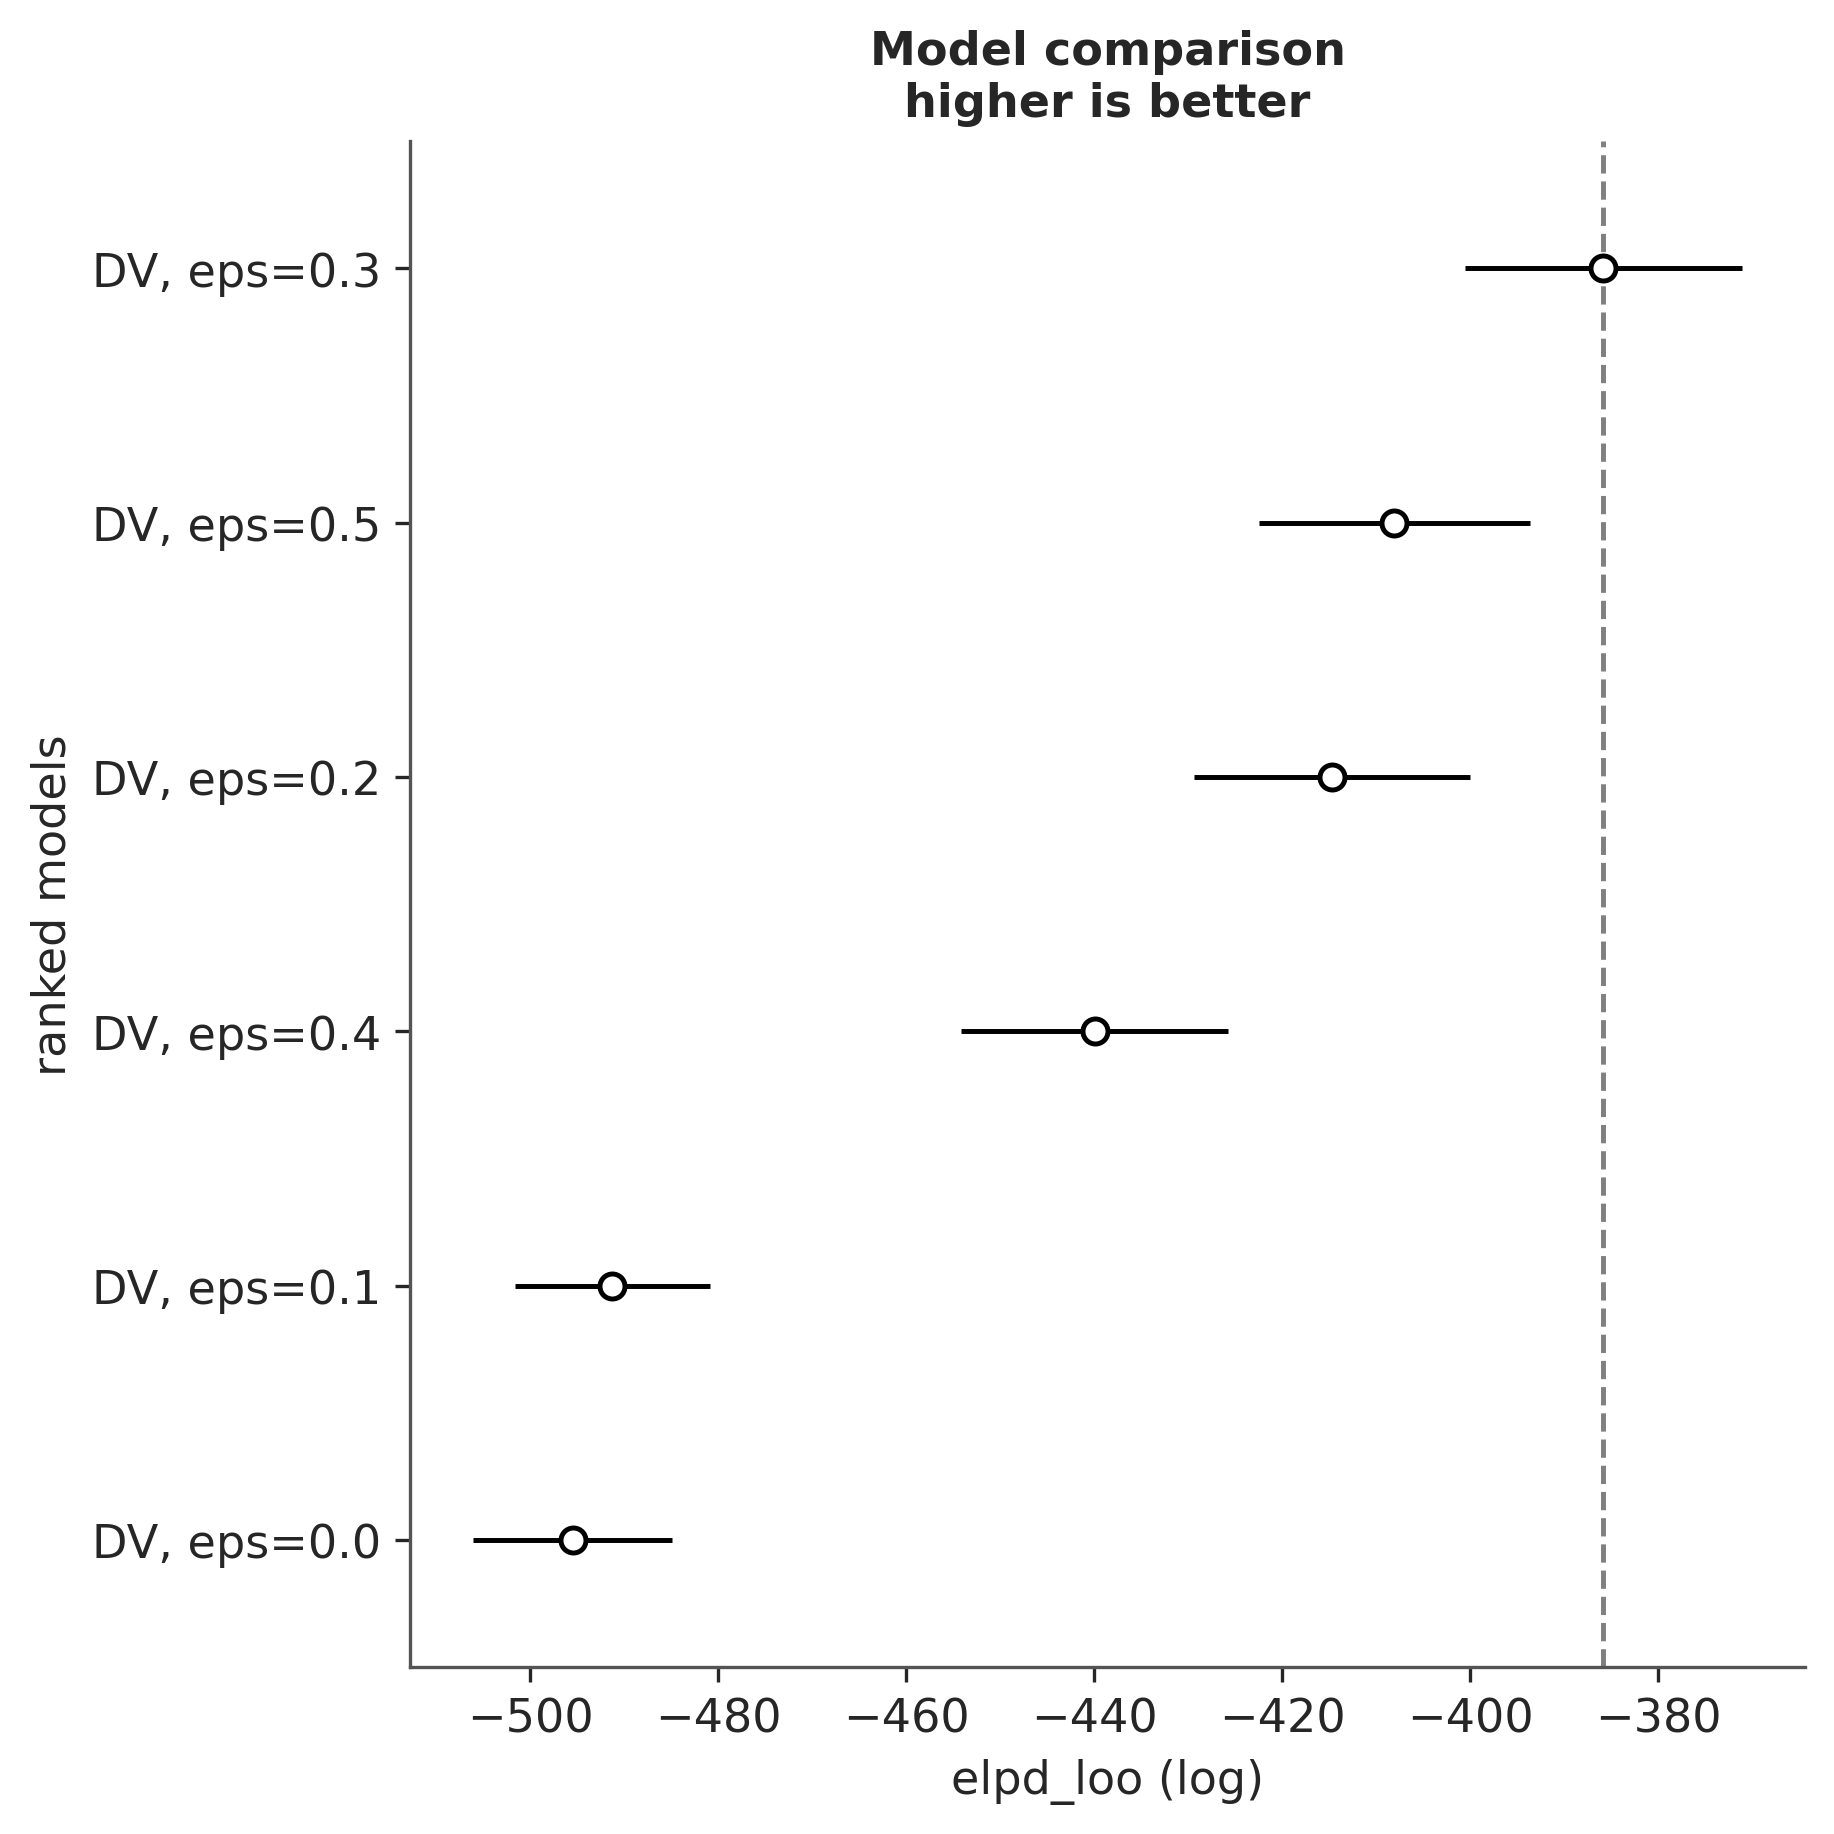

In [ ]:
# Fit models at all epsilons:
traces = dict()

for eps in eps_range:
    # Model the data:
    with pm.Model(coords=coords) as binomial_regression_model:
        x = pm.Data("x", data[f'DV, eps={eps:.2f}'], dims="observation")
        subj_idx = pm.Data("subj_idx", subj_idx_raw, dims="observation")
        # Hyperpriors
        mu_b0 = pm.Normal('mu_b0', mu=0, sigma=2)
        sigma_b0 = pm.HalfNormal('sigma_b0', sigma=2)
        mu_b1 = pm.Normal('mu_b1', mu=0, sigma=2)
        sigma_b1= pm.HalfNormal('sigma_b1', sigma=2)
        
        # Intercept for each subject, distributed around group mean mu_b0
        b0 = pm.Normal('beta0', mu=mu_b0, sigma=sigma_b0, dims="subject")
        # Intercept for each subject, distributed around group mean mu_b1
        b1 = pm.Normal('beta1', mu=mu_b1, sigma=sigma_b1, dims="subject")
        
        # Expected value
        mu = b0[subj_idx] + b1[subj_idx] * x
        pm.Bernoulli("y", logit_p=mu, observed=data["y"], dims="observation")

        traces[f'DV, eps={eps:.2f}'] = pm.sample(500, tune=500, idata_kwargs={"log_likelihood": True})

# Compare models:
model_comparison = az.compare(traces)

# Plot the results of the model comparison:
az.plot_compare(model_comparison)